In [1]:
import torch.nn as nn
import torch.nn.functional as F

class DSSM(nn.Module):
    def __init__(self, n_items, n_requests, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding_items = nn.Embedding(n_items, embedding_dim)
        self.embedding_requests = nn.Embedding(n_requests, embedding_dim)
        
        self.net1 = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.net2 = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        self.last = nn.Linear(2 * hidden_dim, 1)
        
    def forward(self, batch):
        emb_1 = self.embedding_items(batch[0])
        emb_2 = self.embedding_requests(batch[2])
        hid_1 = self.net1(emb_1)
        hid_2 = self.net2(emb_2)
        hid = torch.cat((hid_1, hid_2), 1)
        return self.last(hid)


In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = torch.load('/kaggle/input/dssm-competition-training/model.pt').to(device)
model

DSSM(
  (embedding_items): Embedding(34132265, 16)
  (embedding_requests): Embedding(209250, 16)
  (net1): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
  (net2): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
  (last): Linear(in_features=128, out_features=1, bias=True)
)

In [3]:
emb_items = model.embedding_items.weight.cpu().detach().numpy()
emb_requests = model.embedding_requests.weight.cpu().detach().numpy()

In [4]:
from sklearn.cluster import MiniBatchKMeans

cluster_items = MiniBatchKMeans(50, max_iter=100).fit(emb_items).labels_
cluster_requests = MiniBatchKMeans(50, max_iter=100).fit(emb_requests).labels_

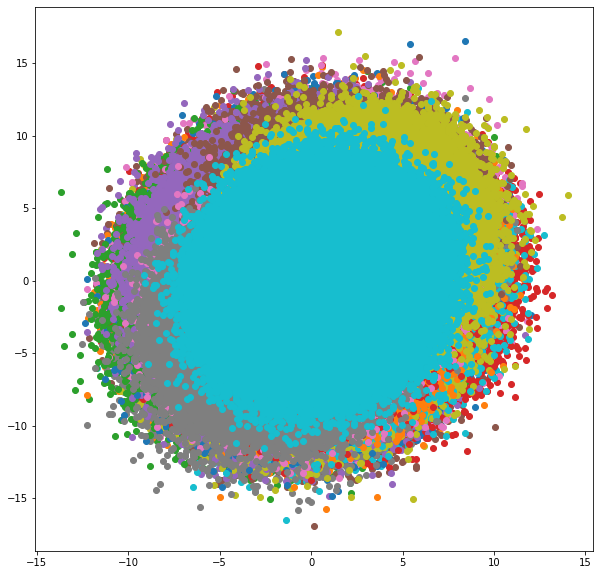

In [5]:
import matplotlib.pyplot as plt
import numpy as np

random_projection_x = emb_items @ np.random.normal(0, 1, emb_items.shape[1]).reshape(-1, 1)
random_projection_y = emb_items @ np.random.normal(0, 1, emb_items.shape[1]).reshape(-1, 1)

plt.figure(figsize=(10, 10))
#plt.xlim(-0.02, 0.02)
#plt.ylim(-0.02, 0.02)
for i in range(1000):
    mask = (cluster_items == i)
    plt.scatter(random_projection_x[mask], random_projection_y[mask])
    
plt.show()


In [6]:
import numpy as np

np.save('cluster_items.npy', cluster_items)
np.save('cluster_requests.npy', cluster_requests)
